# Bollinger bands and RSI strategy
## Simplest, yet quite effective...
- Buy when it is at a discounted px (<= 2 sd) and oversold
- Sell when it is at a premium px (>= 2 sd) and overbought

In [9]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import talib

Extract stocks prices

In [10]:
goog = yf.Ticker('GOOG')

#get historical price (5 years)
df = goog.history(period="5y")
df = df.reset_index()

# Make date to pure date
df['Date'] = pd.to_datetime(df['Date']).dt.date
print(df)

            Date        Open        High         Low       Close    Volume   
0     2018-05-25   53.951000   54.127998   53.688751   53.783001  17988000  \
1     2018-05-29   53.244499   53.668499   52.761002   53.015999  37302000   
2     2018-05-30   53.151501   53.460499   52.841499   53.389999  22770000   
3     2018-05-31   53.377998   54.859501   53.377998   54.249500  61766000   
4     2018-06-01   54.967499   56.000000   54.924999   55.974998  48432000   
...          ...         ...         ...         ...         ...       ...   
1254  2023-05-19  124.199997  126.478996  122.720001  123.250000  30251300   
1255  2023-05-22  123.510002  127.050003  123.449997  125.870003  29760200   
1256  2023-05-23  124.930000  125.419998  123.050003  123.290001  24477900   
1257  2023-05-24  121.879997  122.750000  120.750000  121.639999  22973900   
1258  2023-05-25  125.209999  125.980003  122.900002  124.720001  14113589   

      Dividends  Stock Splits  
0           0.0           0.0  

In [11]:
print(df['Close'].rolling(30).mean())

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
1254    109.885167
1255    110.515834
1256    111.088167
1257    111.635500
1258    112.186500
Name: Close, Length: 1259, dtype: float64


USe TA-Lib for RSI and Bollinger bands

In [12]:
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['Bollinger High'], df['Mean'], df['Bollinger Low'] = talib.BBANDS(df['Close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
print(df)

            Date        Open        High         Low       Close    Volume   
0     2018-05-25   53.951000   54.127998   53.688751   53.783001  17988000  \
1     2018-05-29   53.244499   53.668499   52.761002   53.015999  37302000   
2     2018-05-30   53.151501   53.460499   52.841499   53.389999  22770000   
3     2018-05-31   53.377998   54.859501   53.377998   54.249500  61766000   
4     2018-06-01   54.967499   56.000000   54.924999   55.974998  48432000   
...          ...         ...         ...         ...         ...       ...   
1254  2023-05-19  124.199997  126.478996  122.720001  123.250000  30251300   
1255  2023-05-22  123.510002  127.050003  123.449997  125.870003  29760200   
1256  2023-05-23  124.930000  125.419998  123.050003  123.290001  24477900   
1257  2023-05-24  121.879997  122.750000  120.750000  121.639999  22973900   
1258  2023-05-25  125.209999  125.980003  122.900002  124.720001  14113589   

      Dividends  Stock Splits        RSI  Bollinger High       

Create corresponding strategy function to fit data and spot buy sell signals

In [13]:
def strategy(data):
    pos = 0
    buy_price = []
    sell_price = []
    for i in range(len(data)):
        if data['Close'][i] < data['Bollinger Low'][i] and data['RSI'][i] < 30 and pos == 0:
                buy_price.append(data['Close'][i])
                sell_price.append(np.nan)
                pos = 1
        elif data['Close'][i] > data['Bollinger High'][i] and data['RSI'][i] > 70 and pos == 1:
            sell_price.append(data['Close'][i])
            buy_price.append(np.nan)
            pos = 0
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
    return (buy_price, sell_price)
buy_price, sell_price = strategy(df)
df['Buy'] = buy_price
df['Sell'] = sell_price
print(df)

            Date        Open        High         Low       Close    Volume   
0     2018-05-25   53.951000   54.127998   53.688751   53.783001  17988000  \
1     2018-05-29   53.244499   53.668499   52.761002   53.015999  37302000   
2     2018-05-30   53.151501   53.460499   52.841499   53.389999  22770000   
3     2018-05-31   53.377998   54.859501   53.377998   54.249500  61766000   
4     2018-06-01   54.967499   56.000000   54.924999   55.974998  48432000   
...          ...         ...         ...         ...         ...       ...   
1254  2023-05-19  124.199997  126.478996  122.720001  123.250000  30251300   
1255  2023-05-22  123.510002  127.050003  123.449997  125.870003  29760200   
1256  2023-05-23  124.930000  125.419998  123.050003  123.290001  24477900   
1257  2023-05-24  121.879997  122.750000  120.750000  121.639999  22973900   
1258  2023-05-25  125.209999  125.980003  122.900002  124.720001  14113589   

      Dividends  Stock Splits        RSI  Bollinger High       

Generate PnL reports on results

In [14]:
#PnL results
buy_signals = df['Buy'].dropna().reset_index(drop=True)
sell_signals = df['Sell'].dropna().reset_index(drop=True)
pnl = sell_signals - buy_signals
accruacy = pnl[pnl>0].sum()/abs(pnl).sum()
print('Accruacy (pro-rata): ', accruacy)
print('Total PnL: ', pnl.sum())
print('PnL record in pair:\n', pnl)

Accruacy (pro-rata):  0.533442667722955
Total PnL:  4.1405029296875
PnL record in pair:
 0     5.598999
1    10.709000
2    16.714500
3   -28.881996
dtype: float64


Time horizon per average investment pair (buy & sell)

In [15]:
buy_days = df['Date'][df['Buy'].notna()].reset_index(drop=True)
sell_days = df['Date'][df['Sell'].notna()].reset_index(drop=True)
print('Buy days:\n', buy_days)
print('Sell days:\n', sell_days)
trade_duration = sell_days - buy_days
# transfrom trade_duration to numbers
trade_duration = trade_duration.apply(lambda x: x.days)
print('Trade duration: ', trade_duration)
print('Average trade duration: ', trade_duration.mean())

Buy days:
 0    2018-10-10
1    2019-06-03
2    2020-02-27
3    2022-01-21
Name: Date, dtype: object
Sell days:
 0    2019-03-12
1    2019-07-26
2    2020-08-26
3    2023-01-23
Name: Date, dtype: object
Trade duration:  0    153
1     53
2    181
3    367
Name: Date, dtype: int64
Average trade duration:  188.5


Visualise strategy

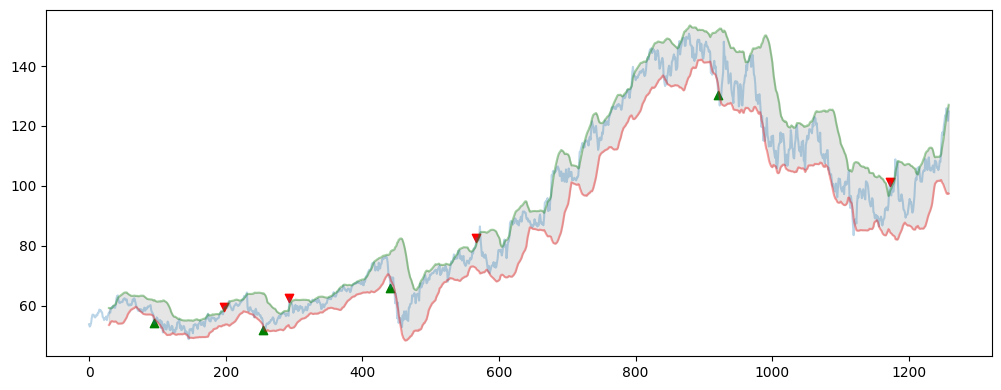

<Figure size 1220x450 with 0 Axes>

<Figure size 1220x450 with 0 Axes>

In [16]:
# Scale the plot size larger to be easier to see, now too packed
plt.figure(figsize=(12.2, 4.5))

plt.plot(df['Close'], label='Close', alpha = 0.3)
plt.plot(df['Bollinger High'], label='Bollinger High', color='green', alpha=0.35)
plt.plot(df['Bollinger Low'], label='Bollinger Low', color='red', alpha=0.35)
plt.fill_between(df.index, df['Bollinger High'], df['Bollinger Low'], color='grey', alpha=0.2)
plt.scatter(df.index, df['Buy'], label='Buy', marker='^', color='green')
plt.scatter(df.index, df['Sell'], label='Sell', marker='v', color='red')
plt.show()

# Scale the plot size larger to be easier to see, now too packed
plt.figure(figsize=(12.2, 4.5))